In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Define the assets we'll analyze
assets = ['TSLA', 'BND', 'SPY']

# Define the time period
end_date = "2025-01-31"
start_date = "2015-01-01"


# Fetch the data
data = yf.download(assets, start=start_date, end=end_date)
print("\nData shape:", data.shape)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Data shape: (2535, 15)


In [6]:
# Display basic information about the dataset
print("\nData columns:")
print(data.columns.levels[0].tolist())
print("\nFirst few rows of Adj Close prices:")
print(data['Close'].head())


Data columns:
['Close', 'High', 'Low', 'Open', 'Volume']

First few rows of Adj Close prices:
Ticker            BND         SPY       TSLA
Date                                        
2015-01-02  62.573151  172.592880  14.620667
2015-01-05  62.754848  169.475891  14.006000
2015-01-06  62.936539  167.879654  14.085333
2015-01-07  62.974388  169.971603  14.063333
2015-01-08  62.875973  172.987732  14.041333


In [7]:
# Extract just the Adjusted Close prices for simplicity
prices = data['Close'].copy()

In [8]:
# Check for missing values
print("\nMissing values in each column:")
print(prices.isna().sum())


Missing values in each column:
Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


In [10]:
# Fill any missing values using forward fill method
if prices.isna().sum().any():
    prices = prices.fillna(method='ffill')
    print("Missing values filled using forward fill")

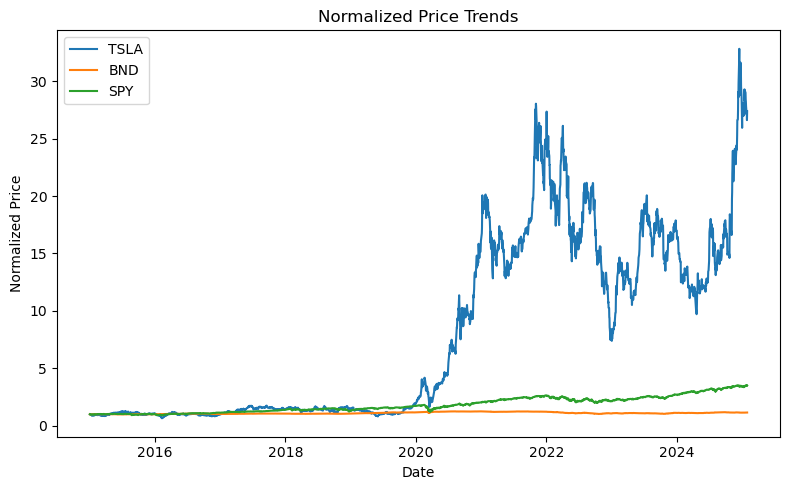

In [15]:
# EXPLORATORY DATA ANALYSIS
# Calculate daily returns
returns = prices.pct_change().dropna()

# Plot the price trends
plt.figure(figsize=(8, 5))
for asset in assets:
    plt.plot(prices.index, prices[asset]/prices[asset].iloc[0], label=asset)
plt.title('Normalized Price Trends')
plt.ylabel('Normalized Price')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

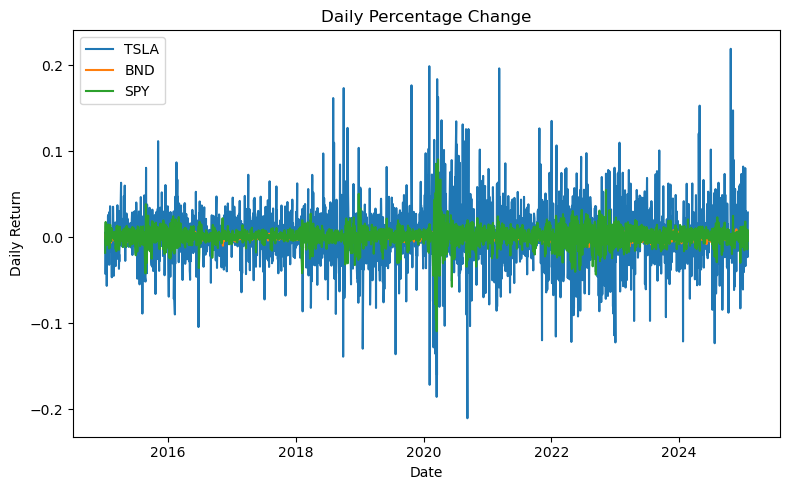

In [16]:
# Plote teh change percentage
plt.figure(figsize=(8,5))
for ticker in assets:
    plt.plot(returns.index, returns[ticker], label=ticker)
plt.title("Daily Percentage Change")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.tight_layout()

In [13]:
# Calculate and display key statistics
print("\nSummary statistics of daily returns:")
summary_stats = returns.describe().T
summary_stats['annualized_return'] = returns.mean() * 252
summary_stats['annualized_volatility'] = returns.std() * np.sqrt(252)
summary_stats['sharpe_ratio'] = summary_stats['annualized_return'] / summary_stats['annualized_volatility']
print(summary_stats[['annualized_return', 'annualized_volatility', 'sharpe_ratio']])



Summary statistics of daily returns:
        annualized_return  annualized_volatility  sharpe_ratio
Ticker                                                        
BND              0.015721               0.054400      0.288983
SPY              0.140314               0.175939      0.797518
TSLA             0.491944               0.571570      0.860690
